## Basic Model


Let's create a basic CNN model and try to familiarize ourselves with the dataset.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.callbacks import ActivationStats
from fastai.vision import *
import pandas as pd
import os

In [2]:
DATA = Path('data')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_TRN_MERGED = DATA/'train_merged.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/trn_noisy'
IMG_TRN_MERGED = WORK/'image/trn_merged'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

train_df = pd.read_csv(CSV_TRN_CURATED)
train_noisy_df = pd.read_csv(CSV_TRN_NOISY)
test_df = pd.read_csv(CSV_SUBMISSION)

In [3]:
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_CURATED, folder='trn_curated', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=',')
)

data = (src.transform(tfms, size=128)
        .databunch(bs=64).normalize(imagenet_stats)
)

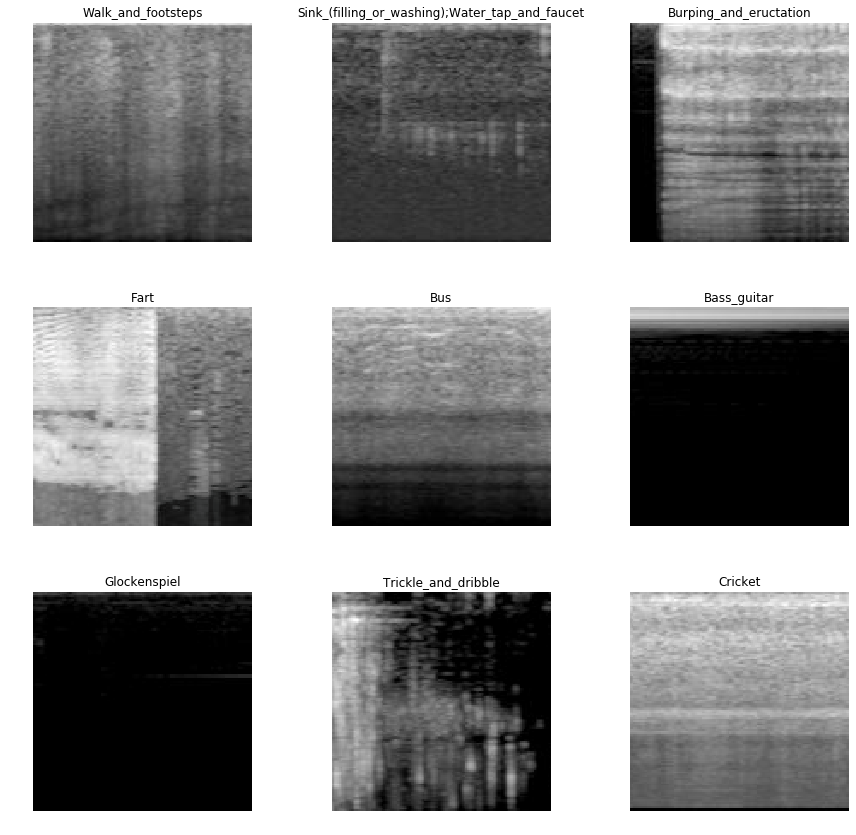

In [4]:
data.show_batch(3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


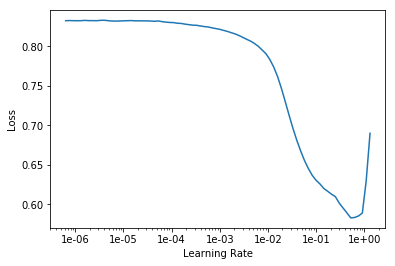

In [5]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=[f_score])

learn.lr_find()
learn.recorder.plot()

In [6]:
learn.fit_one_cycle(5, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,time
0,0.202971,0.090770,0.000000,00:10
1,0.106024,0.077776,0.089282,00:09
2,0.083524,0.071868,0.049781,00:09
3,0.072710,0.060808,0.061661,00:09
4,0.065881,0.058193,0.070663,00:10


In [7]:
learn.unfreeze()
learn.fit_one_cycle(100, slice(1e-6, 1e-1))

epoch,train_loss,valid_loss,fbeta,time
0,0.062135,0.057177,0.087726,00:10
1,0.061018,0.056363,0.090024,00:10
2,0.060101,0.055704,0.110091,00:09
3,0.059378,0.054997,0.115846,00:09
4,0.059039,0.054655,0.135635,00:09
5,0.058751,0.054660,0.143089,00:09
6,0.058739,0.055570,0.130687,00:09
7,0.058554,0.079073,0.152107,00:10
8,0.058696,0.060093,0.142994,00:10
9,0.059459,0.072482,0.199278,00:09


In [8]:
learn.export()

In [9]:
test = ImageList.from_csv(WORK/'image', Path('../..')/CSV_SUBMISSION, folder='test', suffix='.jpg')
learn = load_learner(WORK/'image', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [10]:
test_df[learn.data.classes] = preds
test_df.to_csv('submission.csv', index=False)